Model loaded from file.


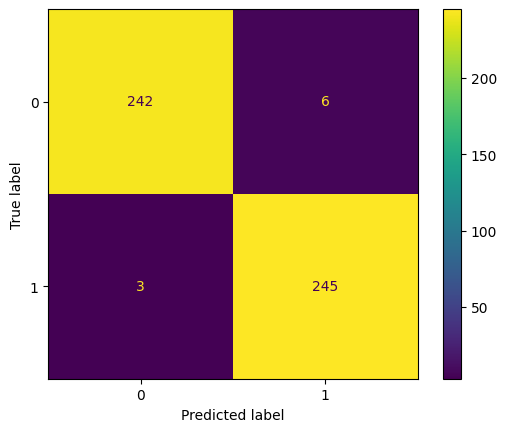


Enter weather parameters for prediction:


Atmospheric pressure (hPa):  1022
Maximum temperature (°C):  21.7
Current temperature (°C):  19
Minimum temperature (°C):  17
Dew point temperature (°C):  18
Humidity (%):  81
Cloud cover (%):  83
Sunshine hours:  0.6
Wind direction (degrees):  50
Wind speed (km/h):  15.3



Rainfall Prediction: Yes
Confidence: 84.0%

Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        58
           1       0.87      0.95      0.91        42

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import joblib
import os

def get_float_input(prompt):
    """Safely get a float input from the user."""
    while True:
        try:
            return float(input(prompt))
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_weather_input():
    """Collect weather parameters from user with validation"""
    print("\nEnter weather parameters for prediction:")
    return {
        'pressure': get_float_input("Atmospheric pressure (hPa): "),
        'maxtemp': get_float_input("Maximum temperature (°C): "),
        'temparature': get_float_input("Current temperature (°C): "),
        'mintemp': get_float_input("Minimum temperature (°C): "),
        'dewpoint': get_float_input("Dew point temperature (°C): "),
        'humidity': get_float_input("Humidity (%): "),
        'cloud': get_float_input("Cloud cover (%): "),
        'sunshine': get_float_input("Sunshine hours: "),
        'winddirection': get_float_input("Wind direction (degrees): "),
        'windspeed': get_float_input("Wind speed (km/h): ")
    }


df = pd.read_csv('Rainfall.csv')
df.columns = df.columns.str.strip()


df['rainfall_label'] = df['rainfall'].map({'yes': 1, 'no': 0})
df = df.dropna(subset=df.columns, how='any')

feature_cols = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
                'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
X = df[feature_cols].fillna(df[feature_cols].mean(numeric_only=True))
y = df['rainfall_label']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


model_path = 'rain_model.pkl'
if os.path.exists(model_path):
    model = joblib.load(model_path)
    print("Model loaded from file.")
else:
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    model.fit(X_train, y_train)
    joblib.dump(model, model_path)
    print("Model trained and saved.")

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_resampled, y_resampled)
plt.show()

user_data = pd.DataFrame([get_weather_input()])
user_scaled = scaler.transform(user_data)
pred_proba = model.predict_proba(user_scaled)[0][1]
prediction = model.predict(user_scaled)


print(f"\nRainfall Prediction: {'Yes' if prediction[0] else 'No'}")
print(f"Confidence: {pred_proba:.1%}")


print("\nModel Performance:")
print(classification_report(y_test, model.predict(X_test)))